# Testing Notebook

After training the model at [train.ipynb](https://github.com/ammar-elsabe/handwritten-digit-recognition-DCNN/blob/master/src/train.ipynb) we need to test its accuracy

## Imports

We begin by importing our dependencies, for testing, we need tensorflow and tensorflow_datasets much like we did with training, but we also need numpy and seaborn

In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## The dataset
We use the [load](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method to load the mnist dataset, but this time, we only load the test split which contains 10000 images

In [2]:
# load the mnist dataset
dstest, dsinfo = tfds.load(
    'mnist',
    split=['test'],  # only need the test set
    data_dir='../dataset/',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

dstest = dstest[0] # Because tfds.load returns a list


2022-04-19 07:54:27.461295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 07:54:27.488776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 07:54:27.488922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 07:54:27.489305: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Preprocessing

We follow the same preprocessing we did while training the model, which is practically nothing that is necessary. However for performance reasons, we autotune and batch the test set

In [3]:
batch_size = 128

# Evaluation pipleine
dstest = dstest.batch(batch_size)
dstest = dstest.cache()
dstest = dstest.prefetch(tf.data.AUTOTUNE)

## The model

We load the model created in the train script

In [4]:
model = tf.keras.models.load_model('./model.h5')

Printing the class names

In [5]:
class_names = dsinfo.features['label'].names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Generating the model predictions

In [6]:
model_probabilities = model.predict(dstest)
pprint(model_probabilities)

2022-04-19 07:54:29.695296: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


array([[1.05488074e-13, 4.06428580e-13, 1.00000000e+00, ...,
        1.50426991e-12, 1.80270687e-10, 1.38228662e-13],
       [1.00000000e+00, 4.13940019e-12, 1.07210969e-10, ...,
        2.79535735e-11, 1.73466415e-11, 6.88162360e-10],
       [1.06815147e-11, 2.52977726e-11, 2.33981758e-11, ...,
        3.18104598e-10, 6.97734188e-13, 2.31907666e-08],
       ...,
       [9.04553255e-12, 1.69623712e-12, 1.11595796e-06, ...,
        1.78048136e-12, 9.99998927e-01, 3.25911628e-12],
       [1.00000000e+00, 2.92407520e-09, 1.37413525e-09, ...,
        2.16336482e-09, 2.72466300e-10, 8.51891802e-09],
       [2.77311796e-09, 8.16450996e-09, 2.15316862e-11, ...,
        1.33693412e-09, 4.72253959e-07, 1.55680038e-06]], dtype=float32)


`model.predict ` returns a list of lists, where each inner list contains the probabilities that image belongs to each class, to get the predicted labels we choose the class with the highest probability

In [11]:
predictions = [np.argmax(x) for x in model_probabilities]
print(predictions)

[2, 0, 4, 8, 7, 6, 0, 6, 3, 1, 8, 0, 7, 9, 8, 4, 5, 3, 4, 0, 6, 6, 3, 0, 2, 3, 6, 6, 7, 4, 9, 3, 8, 2, 5, 4, 2, 5, 5, 8, 5, 2, 9, 2, 4, 2, 7, 0, 5, 1, 0, 7, 9, 9, 9, 6, 5, 8, 8, 6, 9, 9, 5, 4, 2, 6, 8, 1, 0, 6, 9, 5, 5, 4, 1, 6, 7, 5, 2, 9, 0, 6, 4, 4, 2, 8, 7, 8, 3, 0, 9, 0, 1, 1, 9, 4, 5, 9, 1, 6, 6, 0, 7, 7, 8, 4, 8, 8, 1, 8, 0, 2, 9, 1, 0, 3, 9, 7, 0, 4, 9, 6, 8, 9, 3, 5, 4, 3, 2, 2, 4, 0, 3, 2, 3, 5, 1, 1, 2, 4, 8, 2, 2, 6, 8, 6, 1, 7, 0, 6, 1, 7, 7, 3, 4, 4, 6, 9, 0, 8, 2, 8, 6, 0, 9, 7, 8, 2, 9, 0, 2, 3, 2, 8, 7, 0, 1, 7, 8, 5, 1, 2, 3, 1, 9, 8, 7, 9, 0, 8, 3, 9, 3, 9, 7, 4, 9, 3, 1, 2, 2, 6, 0, 7, 6, 9, 5, 9, 7, 4, 2, 0, 1, 0, 4, 9, 9, 1, 9, 2, 2, 0, 5, 6, 0, 0, 2, 7, 7, 4, 7, 5, 1, 7, 7, 8, 2, 5, 9, 6, 6, 8, 0, 1, 2, 1, 7, 7, 7, 3, 0, 3, 4, 8, 3, 6, 3, 8, 2, 0, 7, 5, 7, 2, 0, 8, 5, 8, 6, 7, 1, 7, 1, 0, 1, 8, 6, 5, 1, 5, 3, 1, 9, 0, 8, 5, 7, 1, 0, 0, 6, 7, 4, 1, 7, 1, 2, 4, 4, 8, 9, 1, 0, 8, 5, 3, 5, 8, 9, 9, 1, 8, 0, 1, 3, 9, 7, 1, 8, 4, 6, 7, 6, 6, 2, 1, 2, 4, 9, 7, 7, 2, 5, 

## Evaluation of the model
We get the actual true labels using this one line

In [8]:
labels = np.concatenate([y for x, y in dstest], axis=0)

We then generate a confusion matrix and plot it

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 976,    0,    1,    0,    0,    0,    0,    1,    2,    0],
       [   0, 1129,    1,    1,    0,    0,    1,    1,    2,    0],
       [   1,    0, 1024,    0,    0,    0,    2,    3,    2,    0],
       [   0,    0,    1,  997,    0,   11,    0,    0,    1,    0],
       [   0,    1,    2,    0,  964,    0,    5,    0,    0,   10],
       [   1,    0,    0,    3,    0,  886,    2,    0,    0,    0],
       [   3,    3,    0,    0,    2,    1,  948,    0,    1,    0],
       [   0,    2,    2,    1,    0,    0,    0, 1022,    0,    1],
       [   2,    0,    1,    2,    0,    0,    3,    1,  962,    3],
       [   0,    0,    0,    0,    5,    4,    0,    3,    4,  993]],
      dtype=int32)>


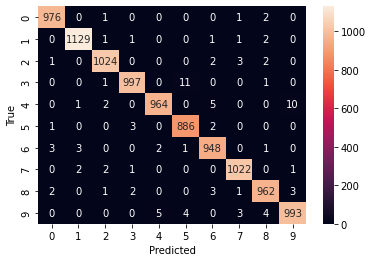

In [9]:
confusion_matrix = tf.math.confusion_matrix(
    labels=labels,
    predictions=predictions,
)
pprint(confusion_matrix)
sns.heatmap(confusion_matrix,
            annot=True,
            xticklabels=class_names,
            yticklabels=class_names,
            fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('../paper/figs/confusion_matrix.svg', format='svg')
plt.show()

With the confusion matrix we can calculate the accurace as
$$
\frac{\sum_i k_{ii}}{\sum_i \sum_j k_{ij}} \times 100
$$

Where $k_{xy}$ represent an element in the $x^{th}$ row and the $y^{th}$ column in the confusion matrix, in other words it is the sum of the elements in the diagonal of the confusion matrix, dividied by the total sum.

In [10]:
diagonal_sum = 0
total_sum = 0

for i in range(len(class_names)):
    for j in range(len(class_names)):
        if(i == j):
            diagonal_sum += confusion_matrix[i][j]
        total_sum += confusion_matrix[i][j]

print("Diagonal sum: {}, Total sum: {}".format(diagonal_sum, total_sum)) # total sum should be 10000 as the test split is 10000 images
accuracy = 100 * diagonal_sum/total_sum
print("Accuracy: {}".format(accuracy))

Diagonal sum: 9901, Total sum: 10000
Accuracy: 99.01
